# Preliminaries

In [ ]:
!pip install optuna
!pip install shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.9/78.9 kB 5.9 MB/s eta 0:00:00


In [ ]:
# All necessary packages
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve, ConfusionMatrixDisplay, precision_score, recall_score, f1_score
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import train_test_split, GridSearchCV,RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import models
import optuna

import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
import pandas as pd
import seaborn as sns
import numpy as np

import shap

import kagglehub

path = kagglehub.dataset_download("gauravduttakiit/smoker-status-prediction-using-biosignals")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/gauravduttakiit/smoker-status-prediction-using-biosignals/versions/1


In [ ]:
#Since no target variable avaliable in the testing dataset in kaggle
#Training dataset has already enough entrie, we can do a train/test split using the training dataset only for this project
df= pd.read_csv(path + "/train_dataset.csv")

#Showcasing the dataset
#df.head()

# Printing information and descriptive statistics for df
print("Training Data Information:")
print(df.info())
print("\nTraining Data Descriptive Statistics:")
print(df.describe().T)

Training Data Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38984 entries, 0 to 38983
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   age                  38984 non-null  int64  
 1   height(cm)           38984 non-null  int64  
 2   weight(kg)           38984 non-null  int64  
 3   waist(cm)            38984 non-null  float64
 4   eyesight(left)       38984 non-null  float64
 5   eyesight(right)      38984 non-null  float64
 6   hearing(left)        38984 non-null  int64  
 7   hearing(right)       38984 non-null  int64  
 8   systolic             38984 non-null  int64  
 9   relaxation           38984 non-null  int64  
 10  fasting blood sugar  38984 non-null  int64  
 11  Cholesterol          38984 non-null  int64  
 12  triglyceride         38984 non-null  int64  
 13  HDL                  38984 non-null  int64  
 14  LDL                  38984 non-null  int64  
 15  hemoglobi

As we can see the taget variable is a binary result consists of 0 and 1 called "smoking", with all other variables already cleaned being in either dummies or numerical values.



# Understanding & Showcasing Features (For Proposal)

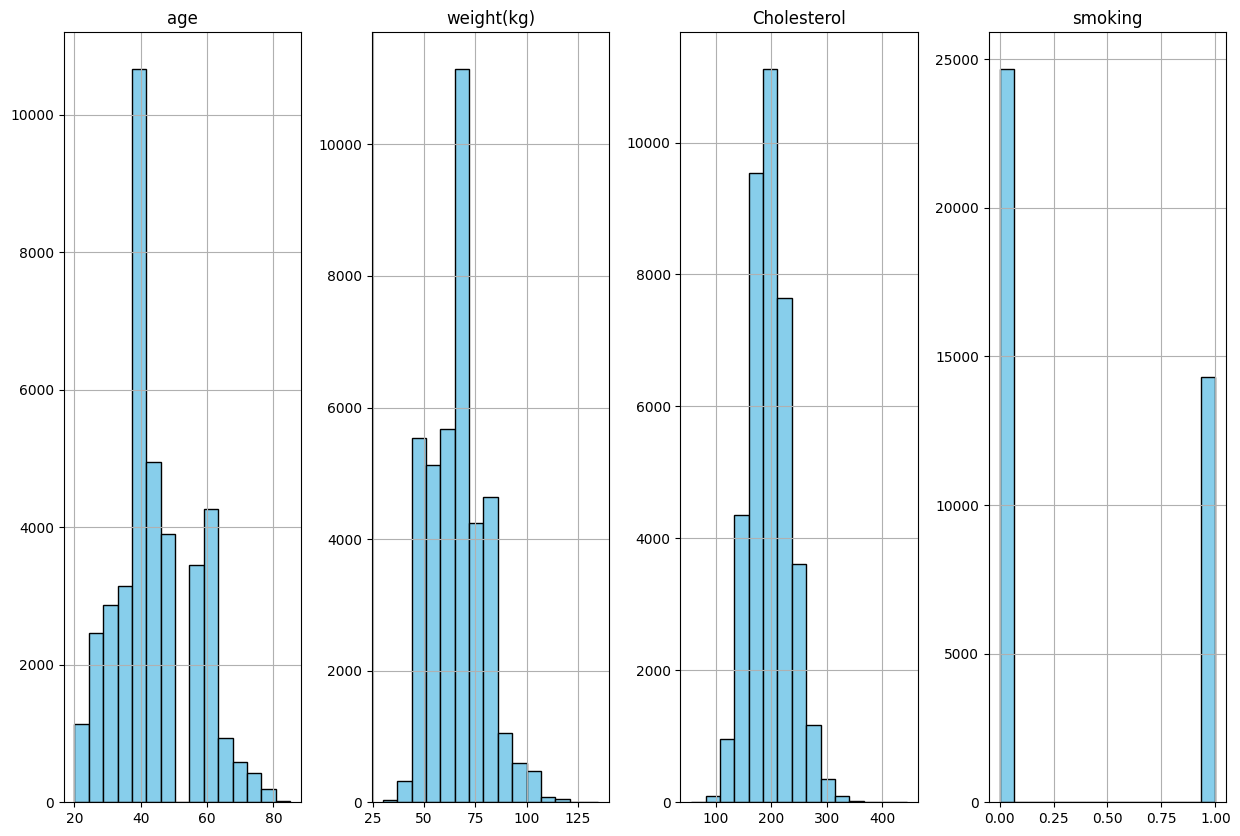

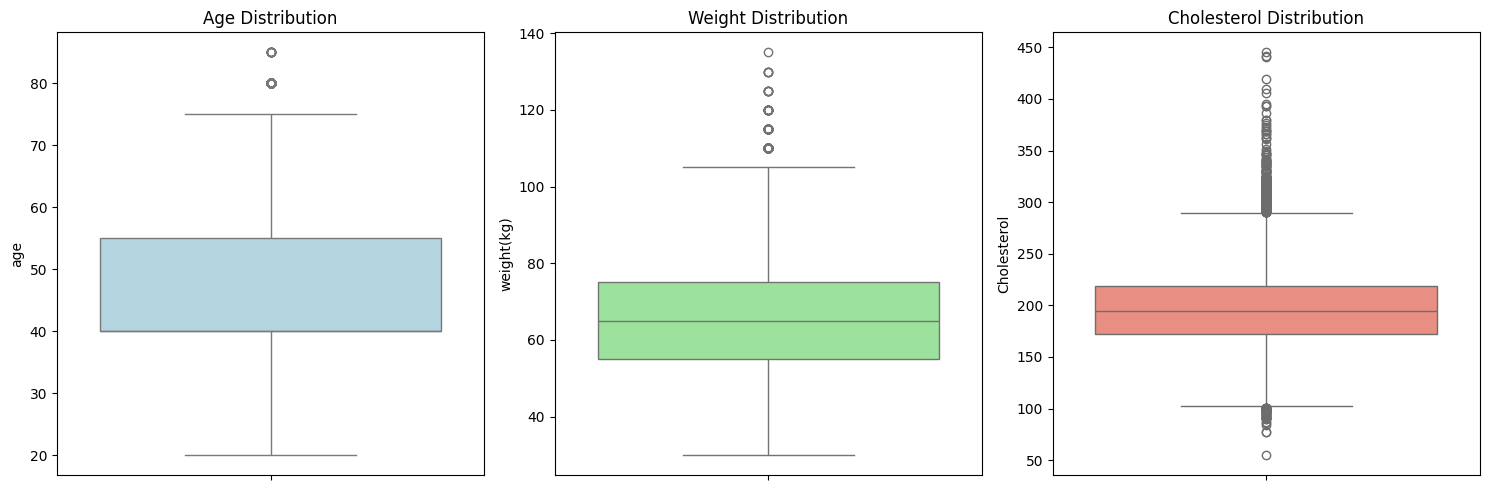

<ipython-input-5-2d8ffc5f4741>:28: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_cholesterol = df.groupby('age_group')['Cholesterol'].mean()


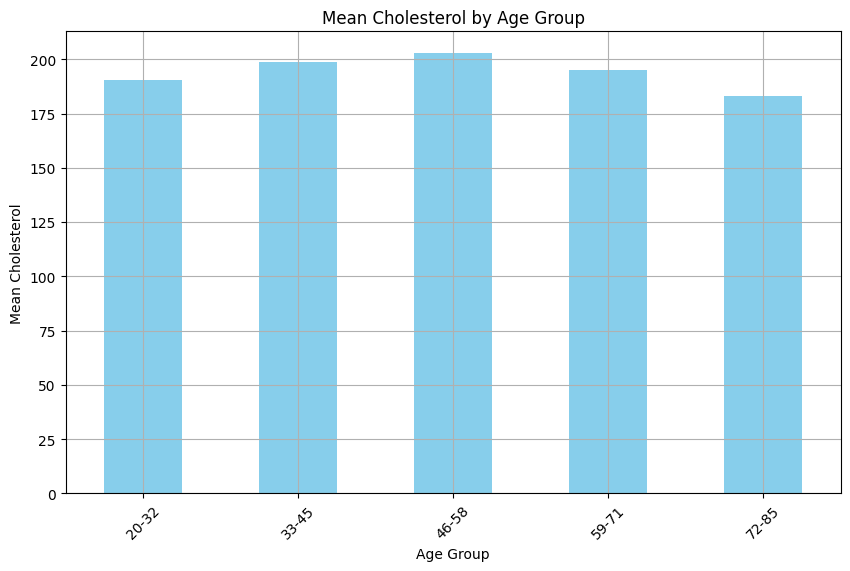

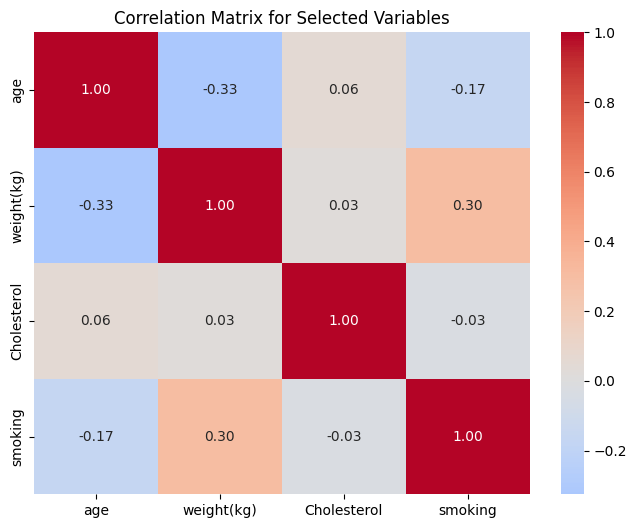

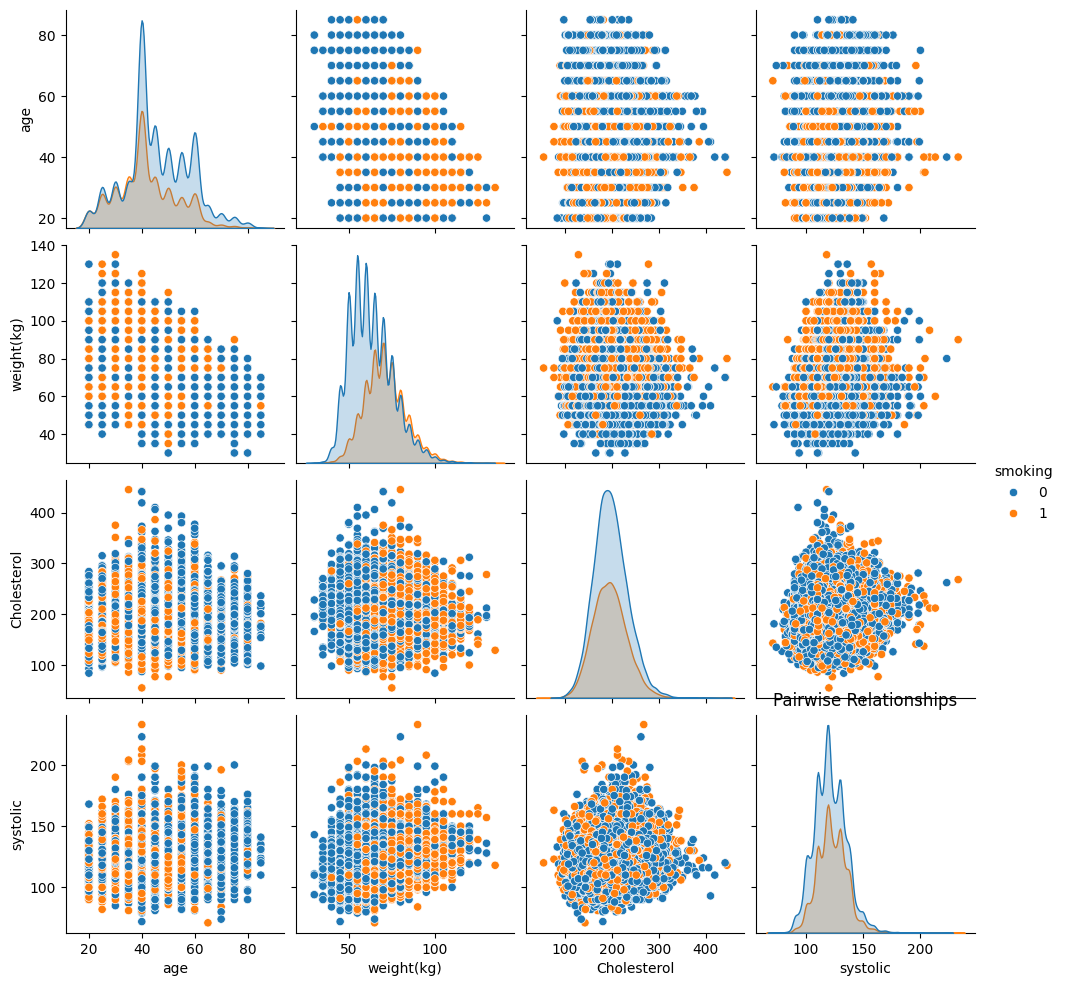

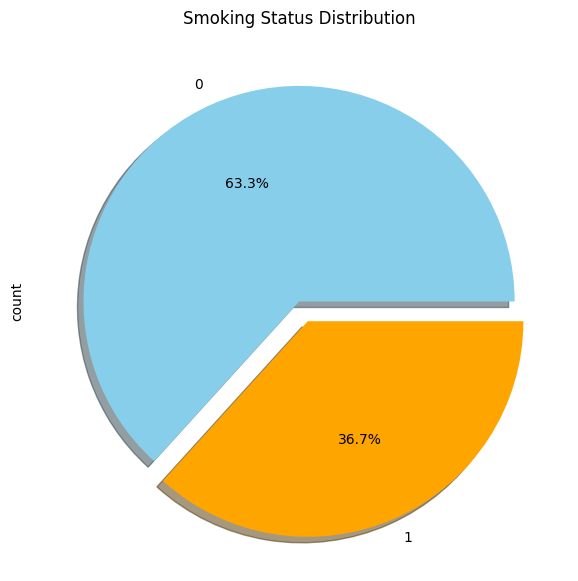

In [ ]:
# Distrubution of key features:
# Set the style
#
# Plot histograms for age, weight, cholesterol
df[['age', 'weight(kg)', 'Cholesterol', 'smoking']].hist(bins=15, figsize=(15, 10), layout=(1, 4), color='skyblue', edgecolor='black')
plt.subplots_adjust(hspace=0.5)
plt.show()


# Boxplot Distrubution of key features:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
sns.boxplot(ax=axes[0], y=df['age'], color='lightblue').set_title('Age Distribution')
sns.boxplot(ax=axes[1], y=df['weight(kg)'], color='lightgreen').set_title('Weight Distribution')
sns.boxplot(ax=axes[2], y=df['Cholesterol'], color='salmon').set_title('Cholesterol Distribution')
plt.tight_layout()
plt.show()


# Mean Cholesterol by Age group:
# Define the age bins and labels for the categorical grouping
bins = [20, 32, 45, 58, 71, 85]
labels = ['20-32', '33-45', '46-58', '59-71', '72-85']

# Create a new column 'age_group' using `pd.cut` to categorize 'age' into bins
df['age_group'] = pd.cut(df['age'], bins=bins, labels=labels, right=True)

# Calculate the mean cholesterol for each age group
mean_cholesterol = df.groupby('age_group')['Cholesterol'].mean()

# Plotting
plt.figure(figsize=(10, 6))
mean_cholesterol.plot(kind='bar', color='skyblue')
plt.title('Mean Cholesterol by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Mean Cholesterol')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


# Confusion matrix for age, weight, cholesterol, and smoking:
# Selecting important features
relevant_data = df[['age', 'weight(kg)', 'Cholesterol', 'smoking']]

# Compute the correlation matrix for the selected variables
corr = relevant_data.corr()

# Generate a heatmap
plt.figure(figsize=(8, 6))  # Adjust the figure size as needed
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", center=0)
plt.title('Correlation Matrix for Selected Variables')
plt.show()

# Pairwise correlation between feature variables:
sns.pairplot(df[['age', 'weight(kg)', 'Cholesterol', 'systolic', 'smoking']], hue='smoking')
plt.title('Pairwise Relationships')
plt.show()

# Distributioin of smoking status:
fig, ax = plt.subplots(figsize=(7, 7))
colors = ['skyblue', 'orange']
df['smoking'].value_counts().plot.pie(
    explode=[0, 0.1],
    autopct='%1.1f%%',
    shadow=True,
    colors=colors
)
ax.set_title('Smoking Status Distribution')
plt.show()

# Train, Val, Test Split

In [ ]:
X = df.drop('smoking', axis=1)
#X = df.drop(['smoking', 'age_group'], axis=1)

y = df['smoking']

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=88)

X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=88)

# Baseline Model for Feature Selection and Correlation

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


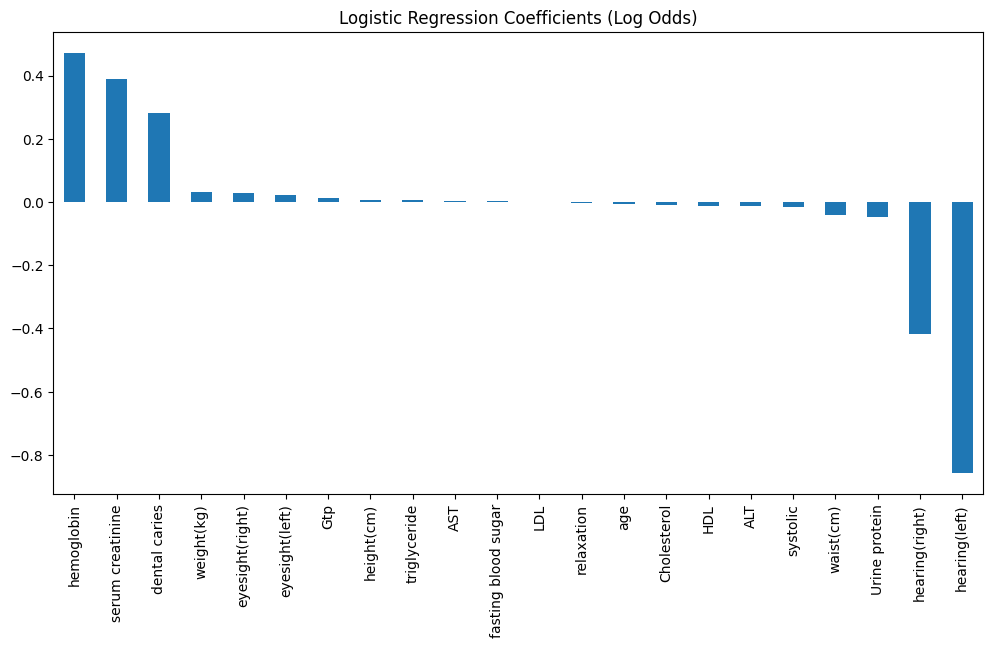

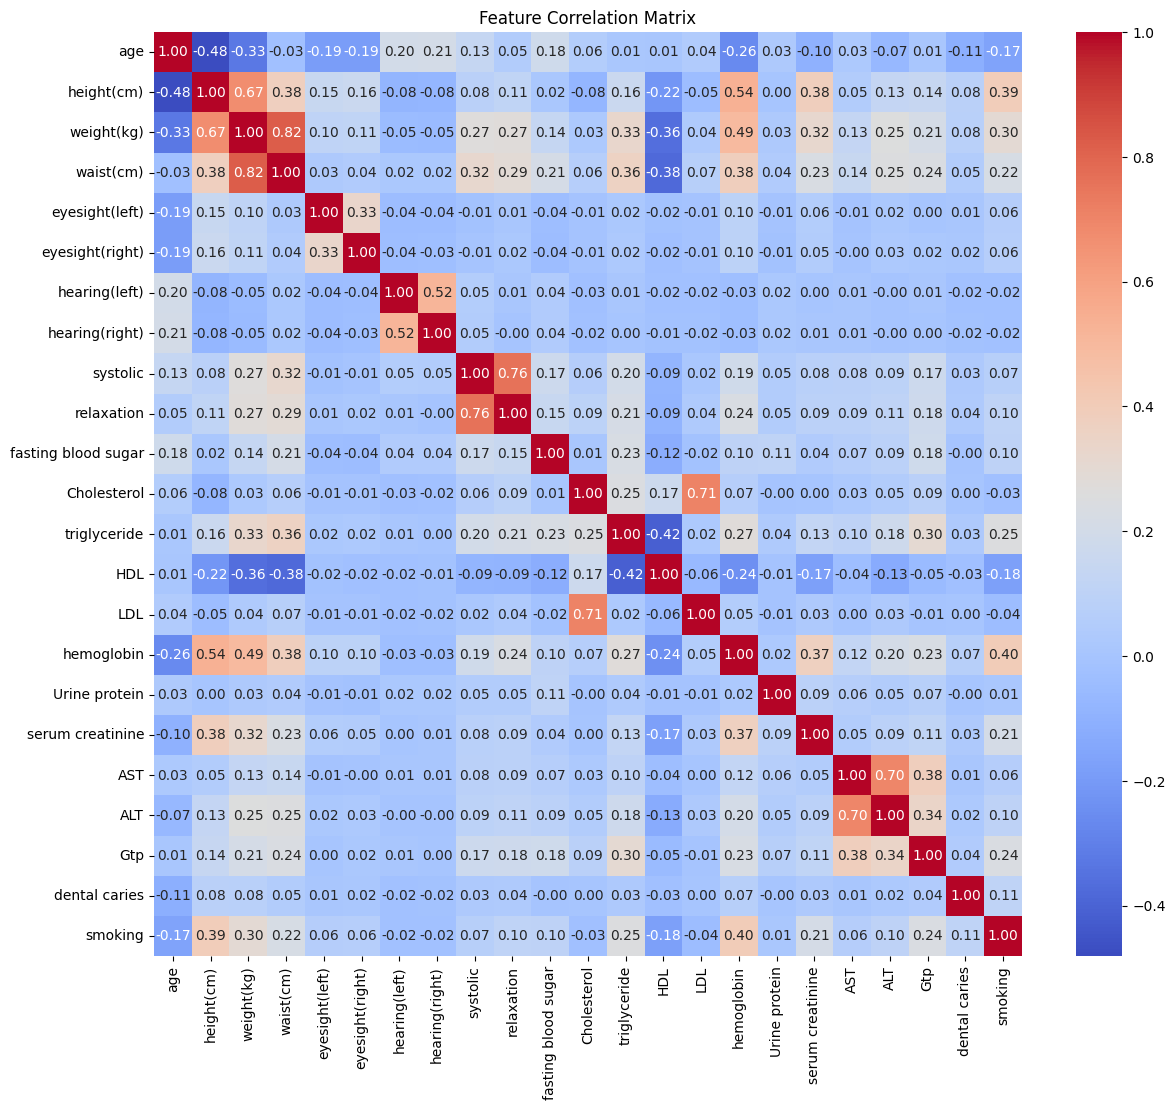

In [ ]:
# Fit the logistic regression model
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)

# Check coefficients (feature importance)
coefficients = pd.Series(log_reg.coef_[0], index=X_train.columns)
coefficients.sort_values(ascending=False).plot(kind='bar', figsize=(12, 6))
plt.title('Logistic Regression Coefficients (Log Odds)')
plt.show()

# Correlation matrix for feature analysis
plt.figure(figsize=(14, 12))
sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Feature Correlation Matrix')
plt.show()

As we see from the very last row of the correlation graph. There are a couple of the features that is fairly useless: hearing(left&right), cholesterol, LDL, Urine protein. these all contribute to less than 0.05 than absolute value, which in our opinion would be considered not significantly contributing to the prediction of the result.

In [ ]:
# Define bins and labels
bins = [20, 32, 45, 58, 71, 85]
labels = ['20-32', '33-45', '46-58', '59-71', '72-85']

# Filter data within the bins
df = df[df['age'].between(bins[0], bins[-1])]

# Create the 'age_group' column (temporary)
age_group = pd.cut(df['age'], bins=bins, labels=labels, right=True)

# Create dummy variables for 'age_group'
age_group_dummies = pd.get_dummies(age_group, prefix='age_group', drop_first=True)

# Ensure dummy variables are integers (1/0)
age_group_dummies = age_group_dummies.astype(int)

# Add dummy variables to the DataFrame (without keeping 'age_group')
df = pd.concat([df, age_group_dummies], axis=1)

In [ ]:
# Drop un-needed columns
X = df.drop(['smoking','hearing(left)','hearing(right)','Cholesterol','LDL', 'Urine protein'], axis=1)

y = df['smoking']

# Train/Test split for the after feature selected data
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=88)

X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=88)

# Pretuning

## Logistic Regression

In [ ]:
# Define pipeline for scaling and model fitting
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LogisticRegression(max_iter=10000, tol=1e-6))
])

# Define hyperparameter grid
param_grid = {
    'model__C': [0.01, 0.1, 1, 10, 100],
    'model__penalty': ['l2'],
    'model__solver': ['lbfgs']
}

# Grid search for hyperparameter tuning
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='roc_auc', verbose=2, n_jobs=-1)
grid_search.fit(X_val, y_val)

# Print best parameters and scores
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best Parameters: {'model__C': 100, 'model__penalty': 'l2', 'model__solver': 'lbfgs'}
Best Score: 0.8125601823091632


## Random Forest

In [ ]:
# Define hyperparameter grid
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt']
}

# Random search for hyperparameter tuning
random_search_RF = RandomizedSearchCV(RandomForestClassifier(random_state=88), param_grid, n_iter=10, cv=3, n_jobs=-1, verbose=2, random_state=88, scoring='roc_auc')
random_search_RF.fit(X_val, y_val)

# Print best parameters and scores
print("\nRandom Forest Pre-tuning:\n")
print("Best Parameters:", random_search_RF.best_params_)
print("Best Score:", random_search_RF.best_score_)



Fitting 3 folds for each of 10 candidates, totalling 30 fits


/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,



Random Forest Pre-tuning:

Best Parameters: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 20}
Best Score: 0.8289384565853828


## Support Vector Machine (LinearSVM)

In [ ]:
# Define the pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),        # Step 1: Scale features
    ('model', LinearSVC(random_state=88))  # Step 2: Fit Linear SVM
])

# Define the hyperparameter grid
param_dist = {
    'model__C': [0.1, 1, 10, 100],
    'model__penalty': ['l1', 'l2'],
    'model__loss': ['squared_hinge'],
    'model__dual': [False],
    'model__tol': [1e-3, 1e-4],
    'model__max_iter': [10000, 20000]
}

# Initialize RandomizedSearchCV
random_search_SVM = RandomizedSearchCV(
    pipeline,
    param_distributions=param_dist,
    n_iter=5,
    cv=5,
    n_jobs=-1,
    verbose=3,
    random_state=88,
    scoring='roc_auc'
)

# Fit the model
print("Starting RandomizedSearchCV for Linear SVM...")
random_search_SVM.fit(X_val, y_val)

# Output results
print("\nLinear SVM Pre-tuning Results:\n")
print("Best Parameters:", random_search_SVM.best_params_)
print("Best Score (AUC-ROC):", random_search_SVM.best_score_)

Starting RandomizedSearchCV for Linear SVM...
Fitting 5 folds for each of 5 candidates, totalling 25 fits

Linear SVM Pre-tuning Results:

Best Parameters: {'model__tol': 0.0001, 'model__penalty': 'l2', 'model__max_iter': 10000, 'model__loss': 'squared_hinge', 'model__dual': False, 'model__C': 10}
Best Score (AUC-ROC): 0.8124868325724087


## Neural Network

In [ ]:
# Step 1: Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# Define the neural network
class SimpleNN(nn.Module):
    def __init__(self, input_size, num_classes=2, dropout_rate=0.5):
        super(SimpleNN, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Dropout(p=dropout_rate),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        return self.layers(x)

# Define the objective function for Optuna
def objective(trial):
    # Suggest hyperparameters
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True)
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64, 128])
    dropout_rate = trial.suggest_float('dropout_rate', 0.3, 0.7)
    num_epochs = trial.suggest_int('num_epochs', 10, 50)

    # Create model
    input_size = X_train.shape[1]  # Number of features in the dataset
    model = SimpleNN(input_size=input_size, num_classes=2, dropout_rate=dropout_rate)

    # DataLoader setup
    train_dataset = TensorDataset(
        torch.tensor(X_train_scaled, dtype=torch.float32),
        torch.tensor(y_train.values, dtype=torch.long)
    )
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Training loop
    model.train()
    for epoch in range(num_epochs):
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    # Evaluate on validation set
    val_dataset = TensorDataset(
        torch.tensor(X_val_scaled, dtype=torch.float32),
        torch.tensor(y_val.values, dtype=torch.long)
    )
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    return accuracy

# Run Optuna hyperparameter optimization
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

# Print best parameters
print("Best Parameters:", study.best_params)

[I 2024-12-06 06:53:18,013] A new study created in memory with name: no-name-f2edd73b-39f4-4957-8bc2-e0cd8f01bda2
[I 2024-12-06 06:53:55,281] Trial 0 finished with value: 0.7431063229447223 and parameters: {'learning_rate': 4.449250307492063e-05, 'batch_size': 16, 'dropout_rate': 0.5866514786698139, 'num_epochs': 10}. Best is trial 0 with value: 0.7431063229447223.
[I 2024-12-06 06:55:48,643] Trial 1 finished with value: 0.7532384250352699 and parameters: {'learning_rate': 3.440980496804714e-05, 'batch_size': 16, 'dropout_rate': 0.33518031981027513, 'num_epochs': 46}. Best is trial 1 with value: 0.7532384250352699.
[I 2024-12-06 06:55:57,704] Trial 2 finished with value: 0.7490060279594716 and parameters: {'learning_rate': 0.0004991044127505773, 'batch_size': 128, 'dropout_rate': 0.62992354372765, 'num_epochs': 18}. Best is trial 1 with value: 0.7532384250352699.
[I 2024-12-06 06:57:07,593] Trial 3 finished with value: 0.7486212645889445 and parameters: {'learning_rate': 3.929119966062

Best Parameters: {'learning_rate': 8.016419338986642e-05, 'batch_size': 32, 'dropout_rate': 0.49910882945178014, 'num_epochs': 49}


# Fitting each of the models

## Logistic Regression

Test Set Accuracy: 0.7250224445299475
Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.81      0.79      4897
           1       0.65      0.58      0.61      2900

    accuracy                           0.73      7797
   macro avg       0.71      0.69      0.70      7797
weighted avg       0.72      0.73      0.72      7797



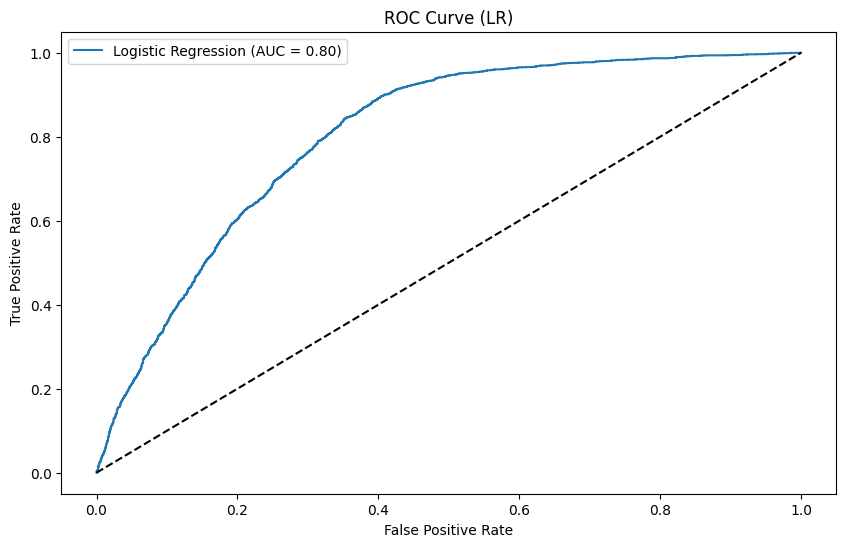

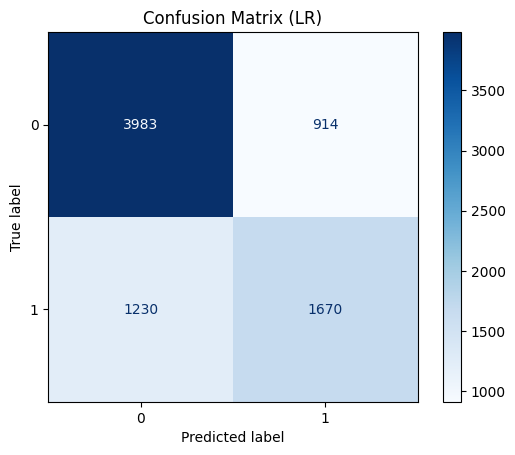

In [ ]:
# Train the model to its full potential using the best parameters
best_model = grid_search.best_estimator_
best_model.fit(X_train, y_train)

# Evaluate the model on the test set
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Test Set Accuracy:", accuracy)
print("Classification Report:\n", classification_report(y_test, y_pred))

# Plot ROC curve
y_prob = best_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label=f'Logistic Regression (AUC = {roc_auc_score(y_test, y_prob):.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (LR)')
plt.legend(loc='best')
plt.show()

# Plot Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix (LR)')
plt.show()

## Random Forest

Test Set Accuracy: 0.7910734898037707
Test Set ROC AUC Score: 0.8686778675191706
Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.84      0.84      4897
           1       0.73      0.71      0.72      2900

    accuracy                           0.79      7797
   macro avg       0.78      0.77      0.78      7797
weighted avg       0.79      0.79      0.79      7797



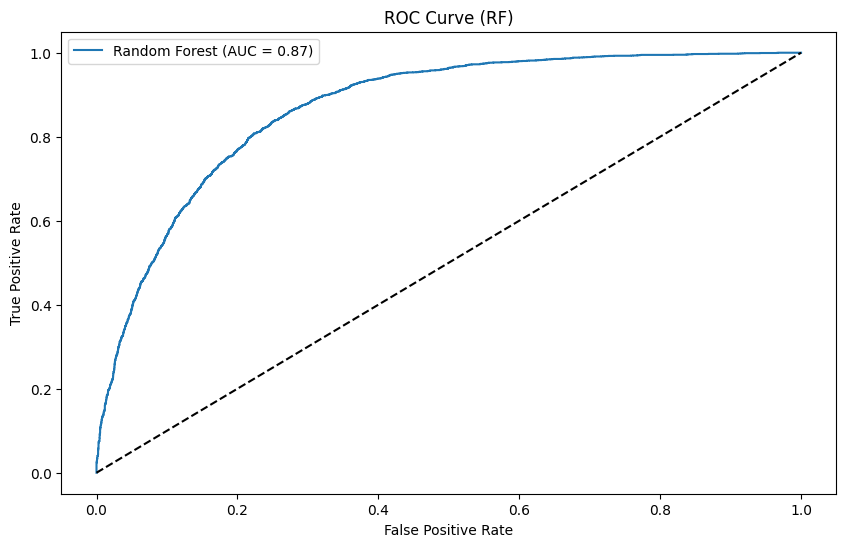

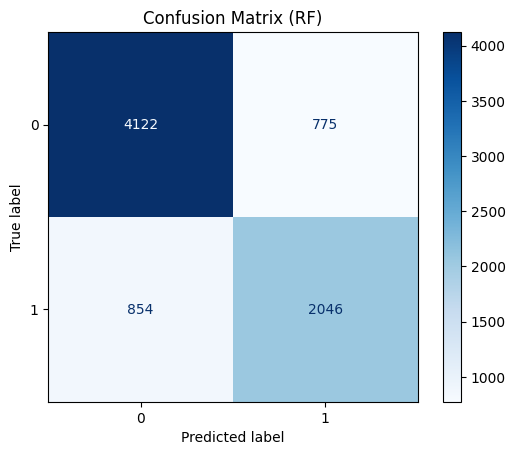

In [ ]:
# Train the model to its full potential using the best parameters
best_params_RF = random_search_RF.best_params_

best_model_RF = RandomForestClassifier(
    n_estimators=best_params_RF['n_estimators'],
    min_samples_split=best_params_RF['min_samples_split'],
    min_samples_leaf=best_params_RF['min_samples_leaf'],
    max_features=best_params_RF['max_features'],
    max_depth=best_params_RF['max_depth'],
    random_state=88  # Ensure reproducibility
)

# Fit the final model on the full training set (X_train, y_train)
best_model_RF.fit(X_train, y_train)

# Evaluate the model on the test set (X_test, y_test)
y_pred = best_model_RF.predict(X_test)
y_prob = best_model_RF.predict_proba(X_test)[:, 1]

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob)


print("Test Set Accuracy:", accuracy)
print("Test Set ROC AUC Score:", roc_auc)
print("Classification Report:\n", classification_report(y_test, y_pred))

# Plot the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label=f'Random Forest (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (RF)')
plt.legend(loc='best')
plt.show()

# Display the confusion matrix
ConfusionMatrixDisplay.from_estimator(best_model_RF, X_test, y_test, cmap='Blues')
plt.title('Confusion Matrix (RF)')
plt.show()

## Linear SVM

Test Set Accuracy: 0.7254072079004745
Test Set ROC AUC Score: 0.8024651968481759
Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.81      0.79      4897
           1       0.65      0.58      0.61      2900

    accuracy                           0.73      7797
   macro avg       0.71      0.70      0.70      7797
weighted avg       0.72      0.73      0.72      7797



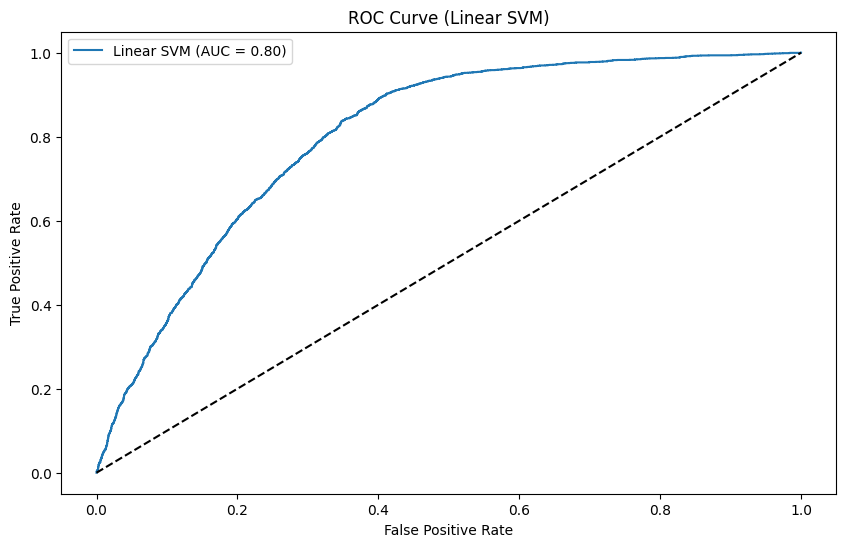

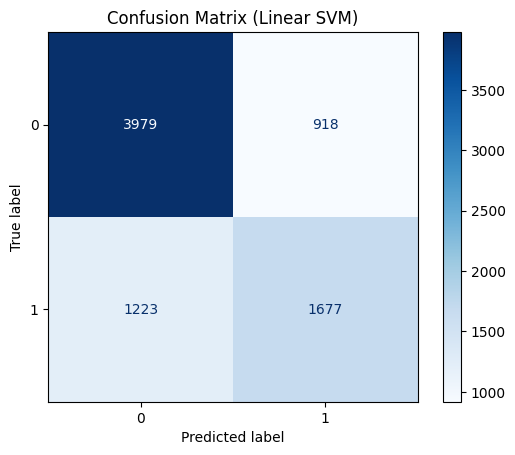

In [ ]:
# Extract best parameters from RandomizedSearchCV
best_params_SVM = random_search_SVM.best_params_

# Initialize the best Linear SVM model with the selected hyperparameters
best_model_SVM = LinearSVC(
    C=best_params_SVM['model__C'],
    penalty=best_params_SVM['model__penalty'],
    loss=best_params_SVM['model__loss'],
    dual=best_params_SVM['model__dual'],
    tol=best_params_SVM['model__tol'],
    max_iter=best_params_SVM['model__max_iter'],
    random_state=88  # Ensure reproducibility
)

# Scale the training and test data (as LinearSVC requires scaled features)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Fit the final Linear SVM model on the full training set
best_model_SVM.fit(X_train_scaled, y_train)

# Evaluate the model on the test set
y_decision = best_model_SVM.decision_function(X_test_scaled)  # Get decision scores for ROC-AUC
y_pred = best_model_SVM.predict(X_test_scaled)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_decision)

print("Test Set Accuracy:", accuracy)
print("Test Set ROC AUC Score:", roc_auc)
print("Classification Report:\n", classification_report(y_test, y_pred))

# Plot the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_decision)
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label=f'Linear SVM (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Linear SVM)')
plt.legend(loc='best')
plt.show()

# Display the confusion matrix
ConfusionMatrixDisplay.from_estimator(best_model_SVM, X_test_scaled, y_test, cmap='Blues')
plt.title('Confusion Matrix (Linear SVM)')
plt.show()

## Neural Network


Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.82      0.81      4897
           1       0.68      0.65      0.66      2900

    accuracy                           0.75      7797
   macro avg       0.74      0.73      0.73      7797
weighted avg       0.75      0.75      0.75      7797



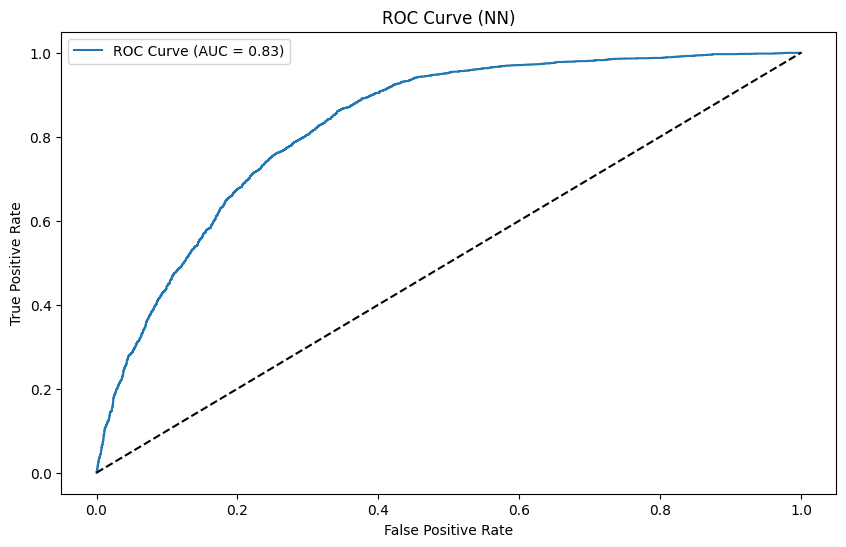

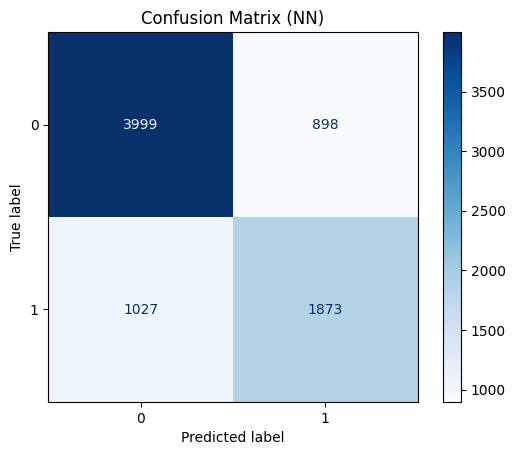

In [ ]:
# Get the best parameters from the Optuna study
best_params_NN = study.best_params

# Train the final model using the best parameters
final_model_NN = SimpleNN(input_size=X_train.shape[1], num_classes=2)
final_model_NN.dropout = best_params_NN['dropout_rate']

# DataLoader setup with the best batch size
train_dataset = TensorDataset(torch.tensor(X_train_scaled, dtype=torch.float32), torch.tensor(y_train.values, dtype=torch.long))
train_loader = DataLoader(train_dataset, batch_size=best_params_NN['batch_size'], shuffle=True)

# Loss and optimizer with the best learning rate
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(final_model_NN.parameters(), lr=best_params_NN['learning_rate'])

# Training loop with the best number of epochs
final_model_NN.train()
for epoch in range(best_params_NN['num_epochs']):
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = final_model_NN(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

# Evaluate on test set
test_dataset = TensorDataset(torch.tensor(X_test_scaled, dtype=torch.float32), torch.tensor(y_test.values, dtype=torch.long))
test_loader = DataLoader(test_dataset, batch_size=best_params_NN['batch_size'], shuffle=False)
final_model_NN.eval()

# Collect predictions and probabilities
y_prob = []
y_pred = []
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = final_model_NN(inputs)
        probabilities = torch.softmax(outputs, dim=1)[:, 1]  # Get probability for positive class
        predictions = torch.argmax(outputs, dim=1)
        y_prob.extend(probabilities.cpu().numpy())
        y_pred.extend(predictions.cpu().numpy())

# Convert y_test to numpy for compatibility
y_test_np = y_test.values

# Display the classification report
print("\nClassification Report:\n", classification_report(y_test_np, y_pred))

# Calculate and plot the ROC curve
roc_auc = roc_auc_score(y_test_np, y_prob)
fpr, tpr, _ = roc_curve(y_test_np, y_prob)
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (NN)')
plt.legend(loc='best')
plt.show()

# Calculate and display the confusion matrix
cm = confusion_matrix(y_test_np, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm).plot(cmap='Blues')
plt.title('Confusion Matrix (NN)')
plt.show()

# Results and Data Visualization

## Logistic Regression

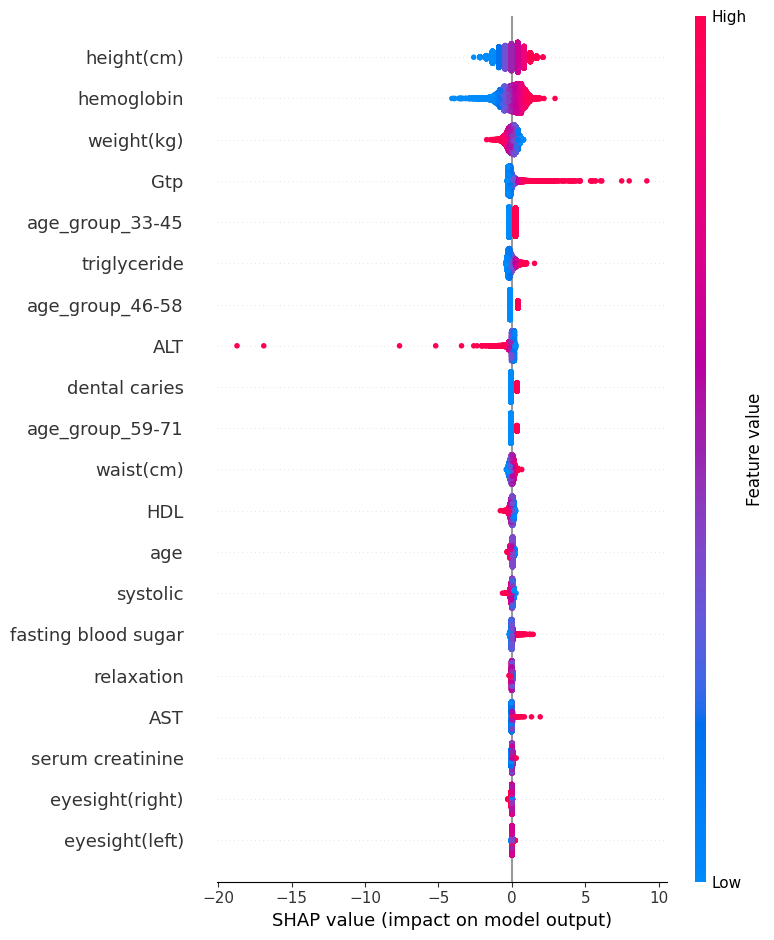

Test Document ID:  88
True Label:  1
Pred Label:  1
Correct Prediction


In [ ]:
# Initialize SHAP explainer for Logistic Regression
logistic_model = best_model.named_steps['model']

explainer = shap.LinearExplainer(logistic_model, X_train_scaled)
shap_values = explainer.shap_values(X_test_scaled)


X_test_array = X_test_scaled

# Summary plot
shap.summary_plot(shap_values, X_test_array, feature_names=X_train.columns)

# Force plot for individual predictions
shap.initjs()

idx = 88  # Example index

print('Test Document ID: ', idx)
print('True Label: ', y_test.iloc[idx] if isinstance(y_test, pd.Series) else y_test[idx])
print('Pred Label: ', y_pred[idx])
print('Correct Prediction' if y_test.iloc[idx] == y_pred[idx] else 'Incorrect Prediction')
display(shap.force_plot(
    explainer.expected_value, shap_values[idx, :], X_test_array[idx, :],
    feature_names=X_train.columns
))

## Random Forest (Take too long due to Random Forest Hyperparameters)

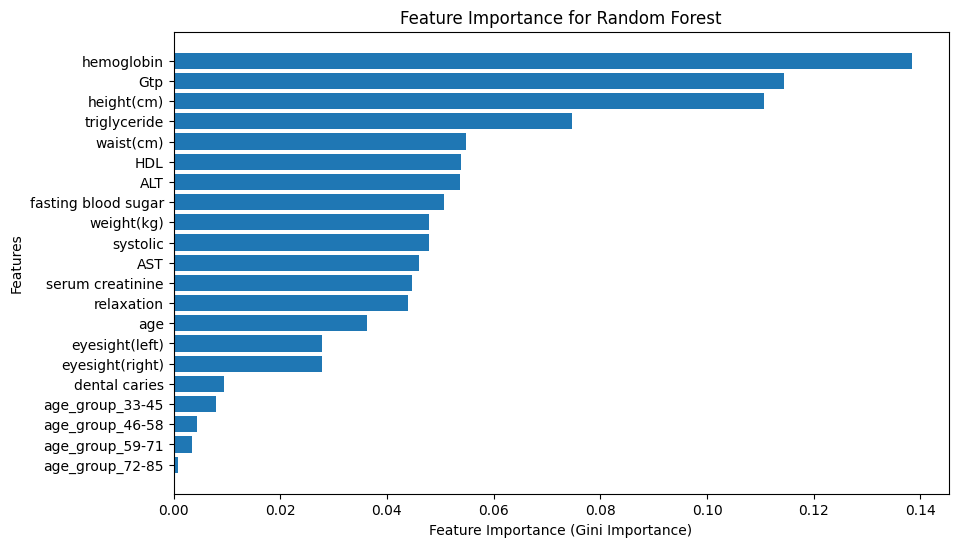

In [ ]:
# Extract feature importances from the trained Random Forest model
feature_importances = best_model_RF.feature_importances_

# Sort features by importance
sorted_idx = np.argsort(feature_importances)[::-1]
sorted_features = np.array(X_train.columns)[sorted_idx]

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(sorted_features, feature_importances[sorted_idx])
plt.xlabel("Feature Importance (Gini Importance)")
plt.ylabel("Features")
plt.title("Feature Importance for Random Forest")
plt.gca().invert_yaxis()  # Flip y-axis for descending order
plt.show()

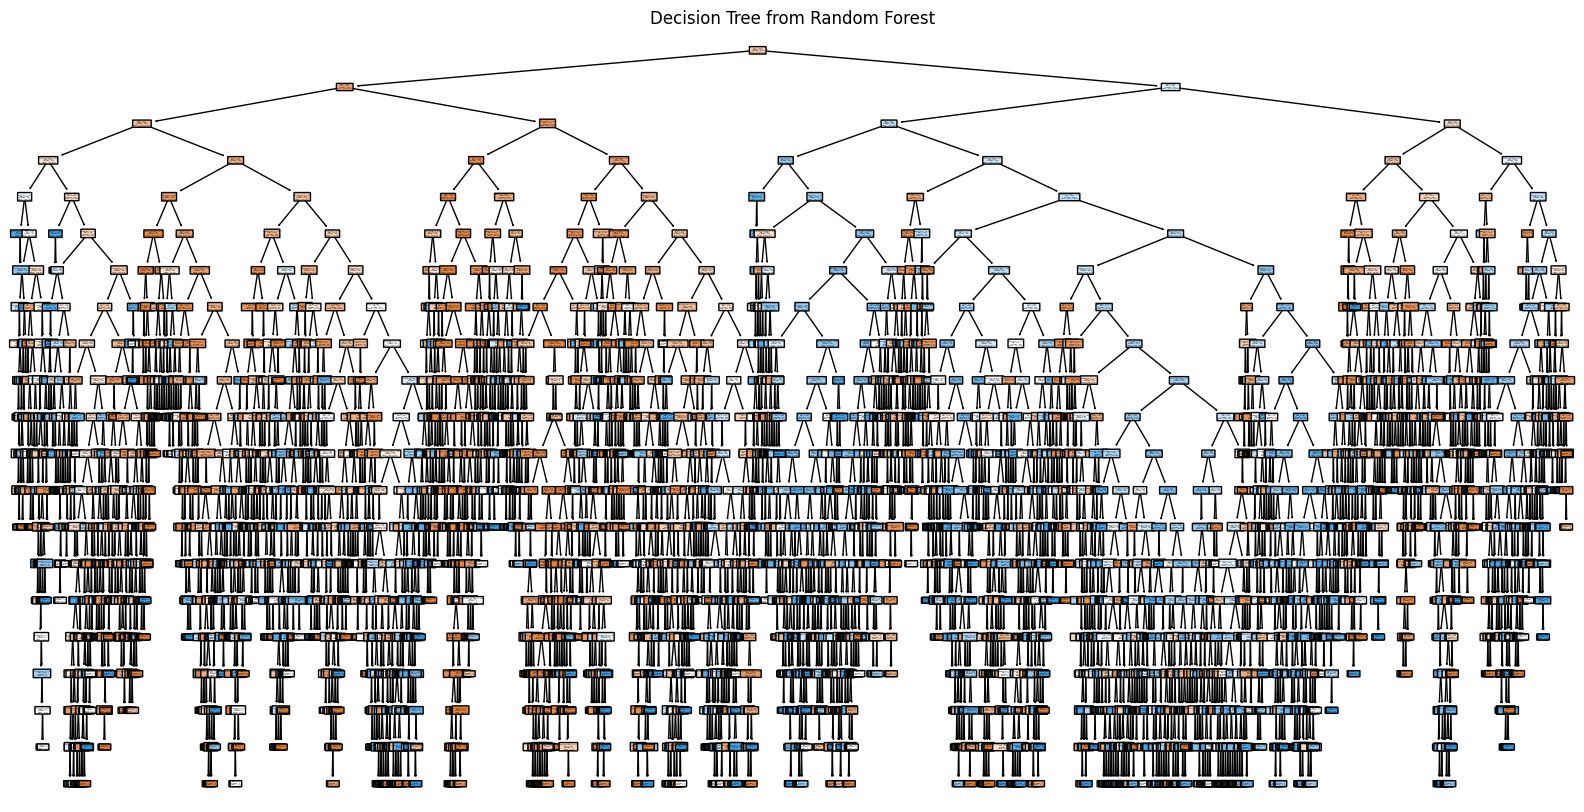

In [ ]:
# Select an individual tree from the Random Forest
tree = best_model_RF.estimators_[0]  # First tree in the forest

# Plot the tree
plt.figure(figsize=(20, 10))
plot_tree(tree,
          filled=True,
          feature_names=X_train.columns,
          class_names=['Non Smoking', 'Smoking'],
          rounded=True)
plt.title("Decision Tree from Random Forest")
plt.show()


## Linear SVM

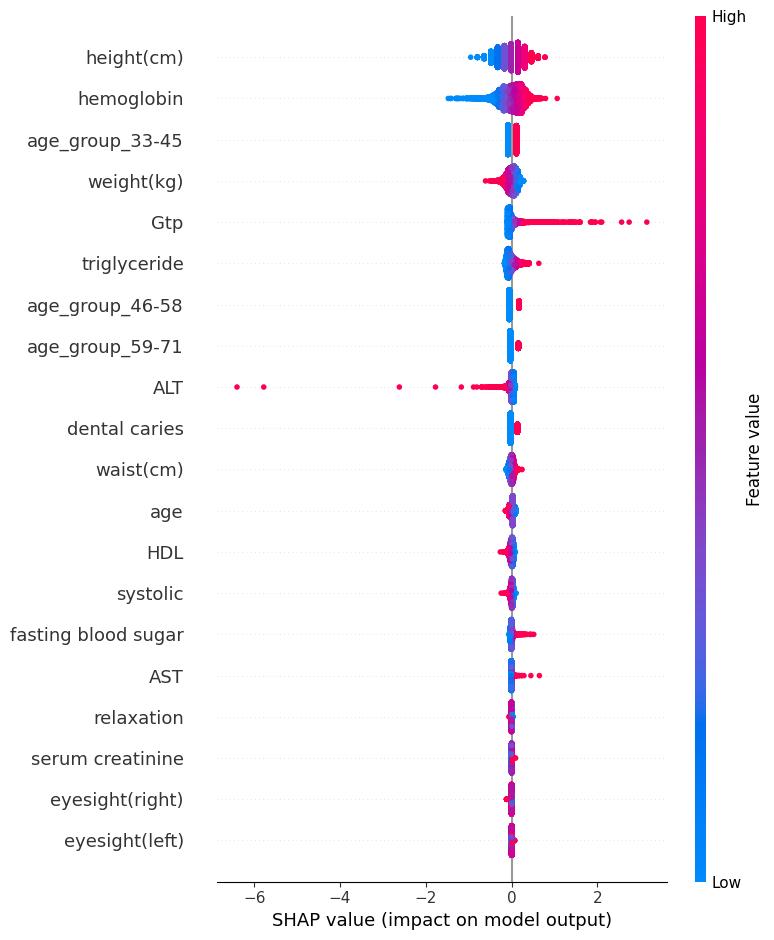

Test Document ID:  1
True Label:  0
Pred Label:  0
Correct Prediction


In [ ]:
# Initialize SHAP explainer for Linear SVM
explainer = shap.LinearExplainer(best_model_SVM, X_train_scaled)
shap_values = explainer.shap_values(X_test_scaled)

# Convert scaled test data to an array if needed
X_test_array = X_test_scaled

# Summary plot
shap.summary_plot(shap_values, X_test_array, feature_names=X_train.columns)

# Force plot for individual predictions
shap.initjs()

idx = 88

print('Test Document ID: ', idx)
print('True Label: ', y_test.iloc[idx])
print('Pred Label: ', y_pred[idx])
print('Correct Prediction' if y_test.iloc[idx] == y_pred[idx] else 'Incorrect Prediction')
display(shap.force_plot(
    explainer.expected_value, shap_values[idx, :], X_test_array[idx, :],
    feature_names=X_train.columns
))


## Neural Network

  0%|          | 0/200 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_least_angle.py:725: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 7 iterations, i.e. alpha=5.055e-03, with an active set of 7 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_least_angle.py:725: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 14 iterations, i.e. alpha=1.009e-03, with an active set of 12 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_least_angle.py:725: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 14 iterations, i.e. alpha=8.585e-04, with an active set of 12 regressors, and the smallest cholesky pivot element bei

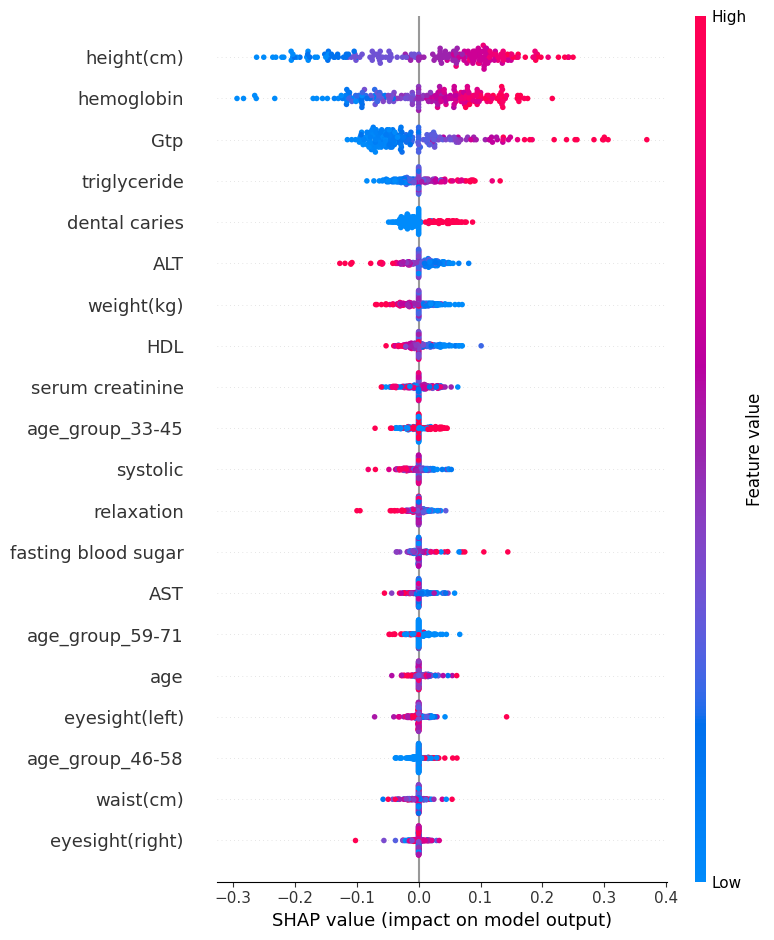

In [ ]:
# Function for prediction
def model_predict(X):
    # Convert NumPy array to PyTorch tensor
    X_tensor = torch.tensor(X, dtype=torch.float32)

    # Ensure the model is in evaluation mode
    final_model_NN.eval()

    # Get predictions
    with torch.no_grad():
        outputs = final_model_NN(X_tensor)
        probabilities = torch.softmax(outputs, dim=1)[:, 1]  # Probability for the positive class
    return probabilities.numpy()

# Reduce background size
background = shap.sample(X_train_scaled, 200, random_state=88)

# Reduce test size
X_test_sample = shap.sample(X_test_scaled, 200, random_state=88)

# Initialize KernelExplainer
explainer = shap.KernelExplainer(model_predict, background)

# Compute SHAP values for the smaller test set
shap_values = explainer.shap_values(X_test_sample, nsamples=50)

# Plot SHAP summary
shap.summary_plot(shap_values, X_test_sample, feature_names=X_train.columns)